# Problem Context

**Background and Context**

In recent times, the field of agriculture has been in urgent need of modernizing, since the amount of manual work people need to put in to check if plants are growing correctly is still highly extensive. Despite several advances in agricultural technology, people working in the agricultural industry still need to have the ability to sort and recognize different plants and weeds, which takes a lot of time and effort in the long term.

The potential is ripe for this trillion-dollar industry to be greatly impacted by technological innovations that cut down on the requirement for manual labor, and this is where Artificial Intelligence can benefit the workers in this field, as the time and energy required to identify plant seedlings will be greatly shortened by the use of AI and Deep Learning. The ability to do so far more efficiently and even more effectively than experienced manual labor could lead to better crop yields, the freeing up of human involvement for higher-order agricultural decision making, and in the long term will result in more sustainable environmental practices in agriculture as well.

# Problem Statement

The Aarhus University Signal Processing group, in collaboration with the University of Southern Denmark, has provided the data containing images of unique plants belonging to 12 different species. You being a data scientist, need to build a Convolutional Neural Network model which would classify the plant seedlings into their respective 12 categories.

# Data Description

This dataset contains images of unique plants belonging to 12 different species.

The data file names are:

images.npy

Label.csv

Due to the large volume of data, the images were converted to numpy arrays and stored in images.npy file and the corresponding labels are also put into Labels.csv so that you can work on the data/project seamlessly without having to worry about the high data volume.

The goal of the project is to create a classifier capable of determining a plant's species from an image.



**List of all the 12 Plant species in the dataset**

Black-grass

Charlock

Cleavers

Common Chickweed

Common Wheat

Fat Hen

Loose Silky-bent

Maize

Scentless Mayweed

Shepherds Purse

Small-flowered Cranesbill

Sugar beet

# Importing the libraries required

In [241]:
##Connect to Google drive to read and write to files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [242]:
#Libraries to help with reading and manipulating data
import numpy as np
import pandas as pd
import cv2 

#Libraries to help with data visualization
import matplotlib.pyplot as plt
import seaborn as sns

#Command to tell python to actually display the graphs
%matplotlib inline

#Importing ImageGrid to plot the images
from mpl_toolkits.axes_grid1 import ImageGrid

# Display images using OpenCV
from google.colab.patches import cv2_imshow # Importing cv2_imshow from google.patches to display images

#For one hot encoding the labels
from sklearn.preprocessing import LabelBinarizer

# Tensorflow modules
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator # Importing the ImageDataGenerator for data augmentation
from tensorflow.keras.models import Sequential, Model   # Importing the sequential module to define a sequential model
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization # Defining all the layers to build our CNN Model
from tensorflow.keras.optimizers import Adam # Importing the optimizers which can be used in our model
from sklearn.model_selection import train_test_split # Importing train_test_split function to split the data into train and test
from sklearn.metrics import classification_report,confusion_matrix  # Importing confusion_matrix to plot the confusion matrix

# Clearing backend
from tensorflow.keras import backend
from keras.applications.vgg16 import VGG16                                                    

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')


# Data Exploration

**Loading the dataset**

In [243]:
# Load the image file of the dataset
images = np.load('/content/drive/MyDrive/Colab Notebooks/images.npy')

# Load the labels file of the dataset
labels = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Labels.csv')

**Overview of the dataset**

In [244]:
print(images.shape)
print(labels.shape)

(4750, 128, 128, 3)
(4750, 1)


There are 4,750 RGB images of shape 128 x 128 X 3, each image having 3 channels.


Let us inspect the labels

In [245]:
labels.sample(5)

Label
1153    Shepherds Purse
1364       Common wheat
3166  Scentless Mayweed
4637   Loose Silky-bent
1214       Common wheat

In [246]:
num_categories = labels['Label'].nunique()
num_categories

12

We have 4,750 labels with 12 unique values. 

In [247]:
# Let us list all the 12 unique plant species
categories = labels.Label.unique()
categories

array(['Small-flowered Cranesbill', 'Fat Hen', 'Shepherds Purse',
       'Common wheat', 'Common Chickweed', 'Charlock', 'Cleavers',
       'Scentless Mayweed', 'Sugar beet', 'Maize', 'Black-grass',
       'Loose Silky-bent'], dtype=object)

In [248]:
labels.value_counts()

Label                    
Loose Silky-bent             654
Common Chickweed             611
Scentless Mayweed            516
Small-flowered Cranesbill    496
Fat Hen                      475
Charlock                     390
Sugar beet                   385
Cleavers                     287
Black-grass                  263
Shepherds Purse              231
Common wheat                 221
Maize                        221
dtype: int64

Out of the 4,750 image samples:

we have 654 samples labeled as Loose Silky-bent - this variety seems to be more in number compared to the rest of the 11 species.

We have 221 samples each of Common wheat and Maize, and these 2 samples are the least in the dataset.

This goes to indicate an imbalance in the dataset.

# Plotting images using OpenCV and matplotlib

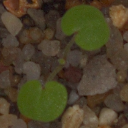

In [249]:
cv2_imshow(images[5])

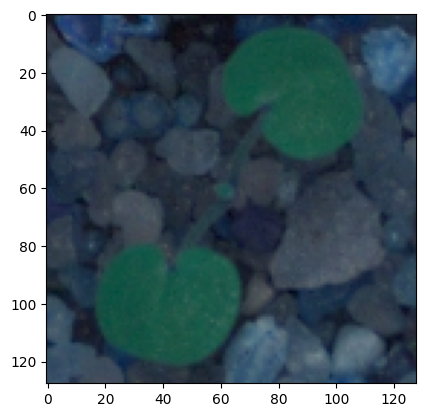

In [250]:
plt.imshow(images[5])

We can observe that the images are being shown in different colors when plotted with openCV and matplotlib as OpenCV reads images in BGR format and this shows that the given numpy arrays were generated from the original images using OpenCV.

Now we will convert these BGR images to RGB images so we could interpret them easily.

In [251]:
# Converting the images from BGR to RGB using cvtColor function of OpenCV
for i in range(len(images)):
  images[i] = cv2.cvtColor(images[i], cv2.COLOR_BGR2RGB)

# Exploratory Data Analysis

**Function to generate labeled Count Plots of the 12 unique types of seedlings available in the dataset**

In [252]:
# function to create countplots with percentages labled on the bars


def labeled_countplot(data, feature, perc=False, n=None):
    """
    Barplot with percentage at the top

    data: dataframe
    feature: dataframe column
    perc: whether to display percentages instead of count (default is False)
    n: displays the top n category levels (default is None, i.e., display all levels)
    """

    total = len(data[feature])  # length of the column
    count = data[feature].nunique()
    if n is None:
        plt.figure(figsize=(count + 1, 3))
    else:
        plt.figure(figsize=(n + 1, 3))

    plt.xticks(rotation=90, fontsize=15)
    ax = sns.countplot(
        data=data,
        x=feature,
        palette="Paired",
        order=data[feature].value_counts().index[:n].sort_values(),
    )

    for p in ax.patches:
        if perc == True:
            label = "{:.1f}%".format(
                100 * p.get_height() / total
            )  # percentage of each class of the category
        else:
            label = p.get_height()  # count of each level of the category

        x = p.get_x() + p.get_width() / 2  # width of the plot
        y = p.get_height()  # height of the plot

        ax.annotate(
            label,
            (x, y),
            ha="center",
            va="center",
            size=12,
            xytext=(0, 5),
            textcoords="offset points",
        )  # annotate the percentage

    plt.show()  # show the plot

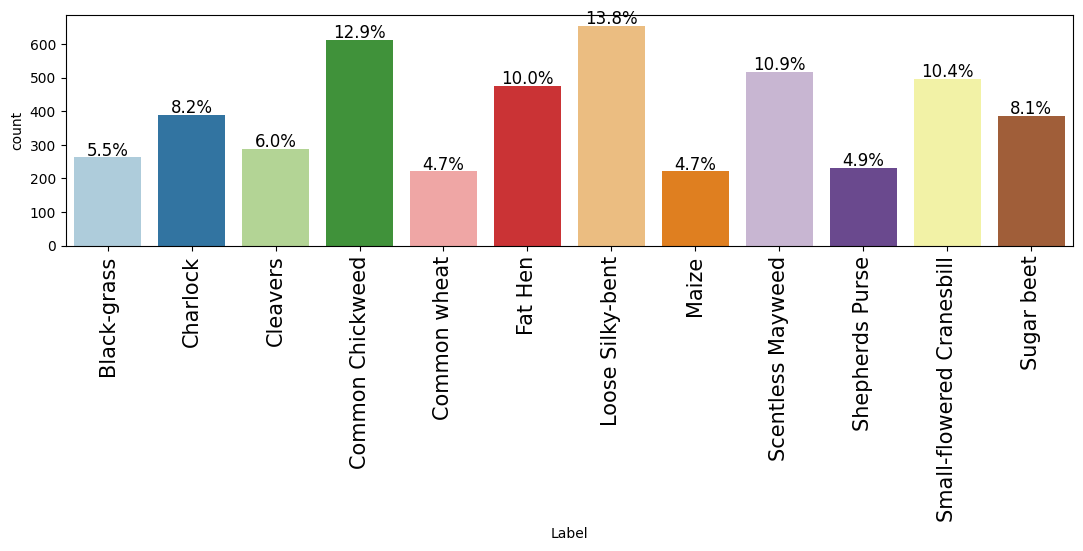

In [253]:
 labeled_countplot(labels,"Label", perc=True) 

**Observation:**

"Loose Silky bent" and Common Chickweed samples are more compared to other categories - they make up 13.8% and 12.9% of the data.

We only have 4.7% of "Common Wheat" and "Maize" samples in the dataset.

**There is an imbalance in the dataset.**

# Displaying the images before the Preprocessing step

**Displaying the images of all the 12 plant categories**

In [254]:
#Function to display all the 12 types of seedlings available in the dataset
def plot_images(images, labels):
    # Chose indices in order to cover all the 12 species
    index_list = [1, 500, 1423, 4745, 3612, 2711,971, 3227, 3833, 2034, 2424, 1202, 4100, 27, 143]
    keys = dict(labels['Label'])
    rows = 3
    cols = 4
    fig = plt.figure(figsize=(10, 8))
    for i, index in enumerate(index_list):
        if i >= rows * cols:  # Break the loop if all desired images are plotted
            break
        ax = fig.add_subplot(rows, cols, i + 1)
        ax.imshow(images[index])
        ax.set_title(keys[index])
    plt.show()

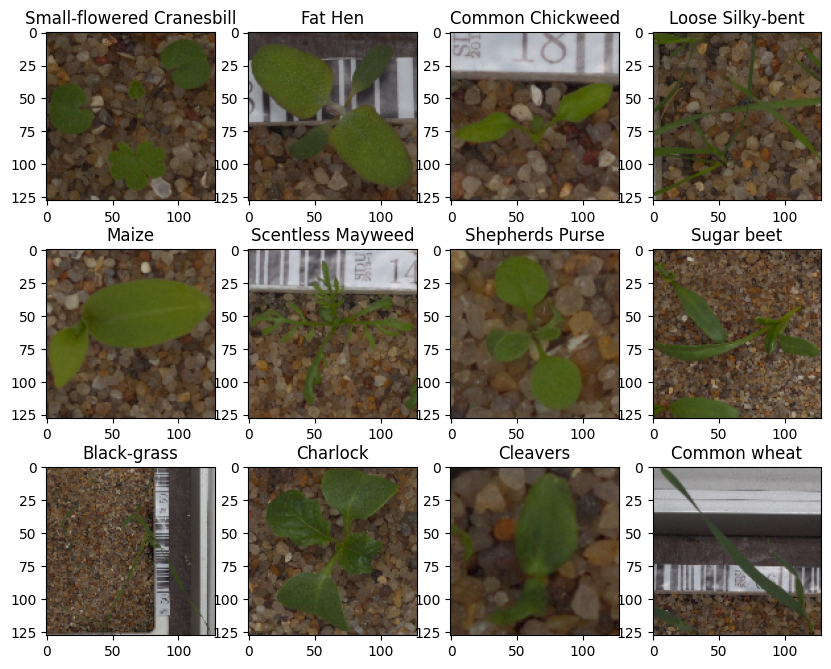

In [255]:
plot_images(images, labels)

# Data Preprocessing

# Resizing images

As the size of the images is large, it may be computationally expensive to train on these larger images; therefore, it is preferable to reduce the image size from 128 to 64.

In [256]:
images_decreased=[]
height = 64
width = 64
dimensions = (width, height)  
for i in range(len(images)):
  images_decreased.append( cv2.resize(images[i], dimensions, interpolation=cv2.INTER_LINEAR))

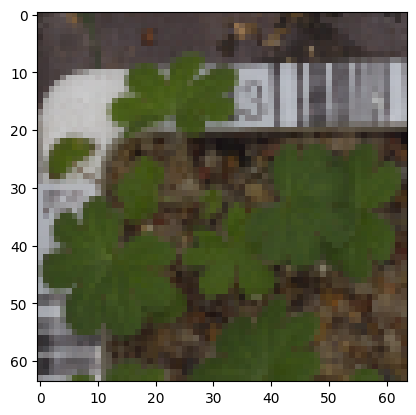

In [257]:
plt.imshow(images_decreased[3])

# Visualizing images using Gaussian Blur

In [258]:
# Applying Gaussian Blur to de-noise the images
images_gb=[]
for i in range(len(images_decreased)):
  images_gb.append(cv2.GaussianBlur(images_decreased[i], ksize =(3,3),sigmaX =  0))

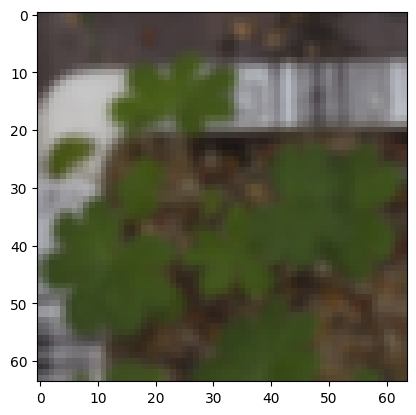

In [259]:
plt.imshow(images_gb[3])

It appears that GaussianBlur would be ineffective because the blurred or denoised image does not seem to contain any relevant information, and the model would struggle to categorize these blurred images.

# Displaying the  Preprocessed images(resized images really)

**Displaying images of the 12 categories after preprocessing**

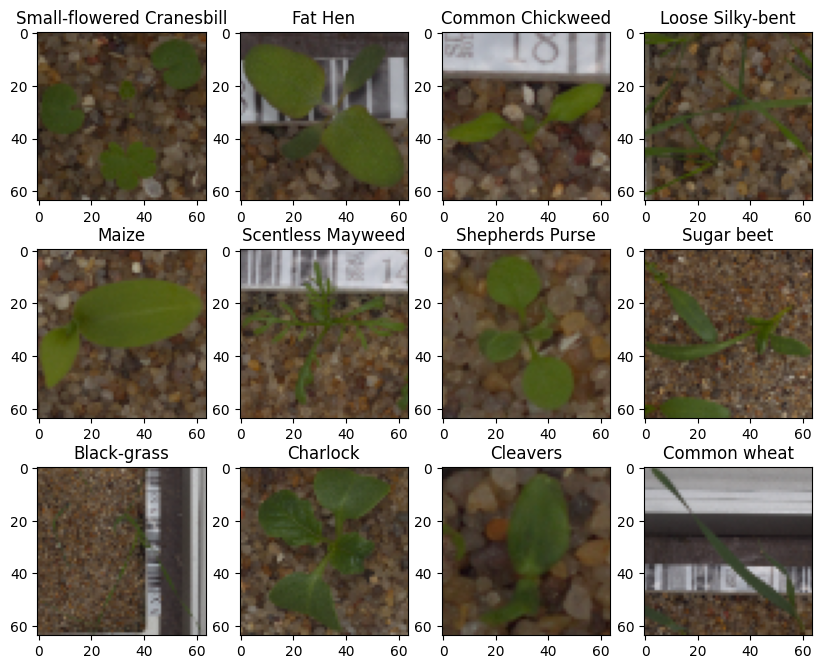

In [260]:
plot_images(images_decreased, labels)

**Plotting the resized images of the 12 plant categories in a 12X12 grid**

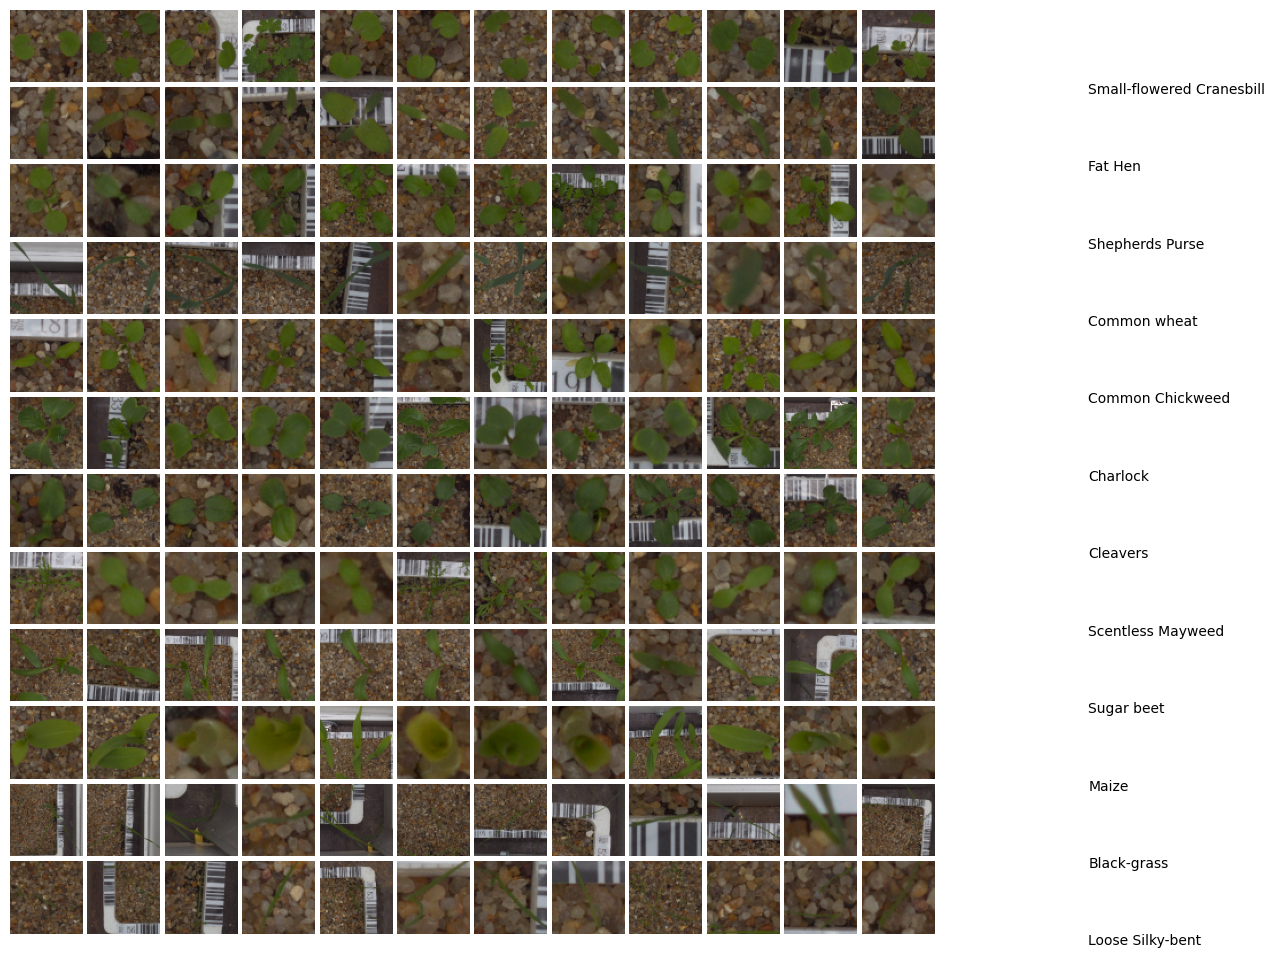

In [261]:
#defining a figure of size 12X12
fig = plt.figure(1, figsize=(num_categories,num_categories))
grid = ImageGrid(fig, 111, nrows_ncols=(num_categories,num_categories), axes_pad=0.05)
i = 0
index = labels.index

#Plottting resized images of the 12 seedling categories
for category_id, category in enumerate(categories):
  condition = labels["Label"] == category
  plant_indices = index[condition].tolist()
  for j in range(0,12):
      ax = grid[i]
      #Using the resized images
      ax.imshow(images_decreased[plant_indices[j]])
      ax.axis('off')
      if i % num_categories == num_categories - 1:
        #printing the names for each caterogy
        ax.text(200, 70, category, verticalalignment='center')
      i += 1
plt.show();

**Resizing the images did not seem to have impacted the quality of the images.** 

# Splitting the dataset


We are using the train_test_split() function from scikit-learn. Here, we split the dataset into three parts, train,test and validation.

20% of the data is set aside for test/unseen data. The remaining is split into training(90%) and validation(10%) datasets. 

In [262]:
X_temp, X_test, y_temp, y_test = train_test_split(np.array(images_decreased),labels , test_size=0.2, random_state=1,stratify=labels)
X_train, X_val, y_train, y_val = train_test_split(X_temp,y_temp , test_size=0.1, random_state=1,stratify=y_temp)

In [263]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3420, 64, 64, 3) (3420, 1)
(380, 64, 64, 3) (380, 1)
(950, 64, 64, 3) (950, 1)


We are using 3,420 images to train the model, 950 images to test the model. 380 images are used to make the validation dataset.

In [264]:
y_train.value_counts()

Label                    
Loose Silky-bent             471
Common Chickweed             440
Scentless Mayweed            372
Small-flowered Cranesbill    357
Fat Hen                      342
Charlock                     281
Sugar beet                   277
Cleavers                     206
Black-grass                  189
Shepherds Purse              167
Common wheat                 159
Maize                        159
dtype: int64

In [265]:
y_test.value_counts()

Label                    
Loose Silky-bent             131
Common Chickweed             122
Scentless Mayweed            103
Small-flowered Cranesbill     99
Fat Hen                       95
Charlock                      78
Sugar beet                    77
Cleavers                      58
Black-grass                   53
Shepherds Purse               46
Common wheat                  44
Maize                         44
dtype: int64

**Treating class imbalance by increasing the weights of the minority classes**.

In [266]:
from sklearn.utils import class_weight

labelList = labels.Label.unique()
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                                  classes = np.array(labelList),
                                                  y = y_train.values.reshape(-1)
                                                  )
class_weights = dict(zip(np.array(range(len(labelList))), class_weights))
#print calculated class weights
class_weights

{0: 0.7983193277310925,
 1: 0.8333333333333334,
 2: 1.7065868263473054,
 3: 1.7924528301886793,
 4: 0.6477272727272727,
 5: 1.0142348754448398,
 6: 1.383495145631068,
 7: 0.7661290322580645,
 8: 1.0288808664259927,
 9: 1.7924528301886793,
 10: 1.507936507936508,
 11: 0.6050955414012739}

# Making the data compatible:

*   Convert labels from names to one hot vectors
*   Normalizing the values





# Encoding the target labels

In [267]:
# Convert labels from names to one hot vectors.
# Labelbinarizer works similar to onehotencoder 

encoder = LabelBinarizer()
y_train_encoded = encoder.fit_transform(y_train)
y_val_encoded=encoder.transform(y_val)
y_test_encoded=encoder.transform(y_test)

In [268]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3420, 64, 64, 3) (3420, 1)
(380, 64, 64, 3) (380, 1)
(950, 64, 64, 3) (950, 1)


**Visualise the one hot encoded labels in y_train, y_test & y_val**

In [269]:
print(" y_train_encoded[0]:", y_train_encoded[0])
print(" y_test_encoded[10]:", y_test_encoded[10])
print(" y_val_encoded[100]:", y_val_encoded[100])

 y_train_encoded[0]: [0 0 0 0 0 0 1 0 0 0 0 0]
 y_test_encoded[10]: [0 1 0 0 0 0 0 0 0 0 0 0]
 y_val_encoded[100]: [0 0 0 0 0 0 0 1 0 0 0 0]


# Data Normalization

Since the image pixel values range from 0-255, our method of normalization here will be scaling - we shall divide all the pixel values by 255 to standardize the images to have values between 0-1.

In [270]:
# Normalizing the image pixels
X_train_normalized = X_train.astype('float32')/255.0
X_val_normalized = X_val.astype('float32')/255.0
X_test_normalized = X_test.astype('float32')/255.0


In [271]:
print(X_train.shape,y_train.shape)
print(X_val.shape,y_val.shape)
print(X_test.shape,y_test.shape)

(3420, 64, 64, 3) (3420, 1)
(380, 64, 64, 3) (380, 1)
(950, 64, 64, 3) (950, 1)


**Data is in the shape compatible with Keras models and does not need to be reshaped.**

# Model Building - Convolutional Neural Network (CNN)



Let's create a CNN model sequentially, where we will be adding the layers one after another.

First, we need to clear the previous model's history from the session even if a single model can run multiple times on the same data.

In Keras, we need a special command to clear the model's history, otherwise the previous model history remains in the backend.

Also, let's fix the seed again after clearing the backend.

Let's set the seed for random number generators in Numpy, the Random library in Python, and in TensorFlow to be able to reproduce the same results every time we run the code.

In [272]:
# Clearing backend
backend.clear_session()

In [273]:
# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

Now, let's build a CNN Model with the following 2 main parts -

The Feature Extraction layers which are comprised of convolutional and pooling layers.

The Fully Connected classification layers for prediction.


**Building Model1**

In [274]:
# Intializing a sequential model
model1 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension of images
model1.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model1.add(MaxPooling2D((2, 2), padding = 'same'))

model1.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model1.add(MaxPooling2D((2, 2), padding = 'same'))

# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model1.add(Flatten())

# Adding a fully connected dense layer with 100 neurons    
model1.add(Dense(100, activation='relu'))

# Adding the output layer with 12 neurons (12 distinct labels) and activation function as softmax since this is a multi-class classification problem  
model1.add(Dense(12, activation='softmax'))


optimizer=Adam()
# Compile model
model1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 100)               8

**Fitting model1 on training data**

In [275]:
history_1 = model1.fit(
            X_train_normalized, y_train_encoded,
            epochs=30,
            class_weight=class_weights,   #using the class_weights generated to handle imbalanced data
            validation_data=(X_val_normalized,y_val_encoded),
            batch_size=64,
            verbose=2
)


Epoch 1/30
54/54 - 2s - loss: 2.7327 - accuracy: 0.1778 - val_loss: 2.2195 - val_accuracy: 0.3263 - 2s/epoch - 42ms/step
Epoch 2/30
54/54 - 0s - loss: 2.0088 - accuracy: 0.3766 - val_loss: 1.6488 - val_accuracy: 0.4342 - 499ms/epoch - 9ms/step
Epoch 3/30
54/54 - 1s - loss: 1.4478 - accuracy: 0.5322 - val_loss: 1.2788 - val_accuracy: 0.5947 - 504ms/epoch - 9ms/step
Epoch 4/30
54/54 - 0s - loss: 1.1863 - accuracy: 0.6035 - val_loss: 1.2744 - val_accuracy: 0.5789 - 498ms/epoch - 9ms/step
Epoch 5/30
54/54 - 0s - loss: 1.0481 - accuracy: 0.6532 - val_loss: 1.1389 - val_accuracy: 0.6237 - 496ms/epoch - 9ms/step
Epoch 6/30
54/54 - 0s - loss: 0.9083 - accuracy: 0.7073 - val_loss: 0.9883 - val_accuracy: 0.6868 - 494ms/epoch - 9ms/step
Epoch 7/30
54/54 - 0s - loss: 0.7908 - accuracy: 0.7450 - val_loss: 0.9785 - val_accuracy: 0.6895 - 497ms/epoch - 9ms/step
Epoch 8/30
54/54 - 0s - loss: 0.6714 - accuracy: 0.7863 - val_loss: 0.9617 - val_accuracy: 0.6763 - 500ms/epoch - 9ms/step
Epoch 9/30
54/54 -

**The model seems to be overfitting - with ~100% accuracy in the training data set vs ~73% accuracy in the validation dataset.**

# Model1 Evaluation

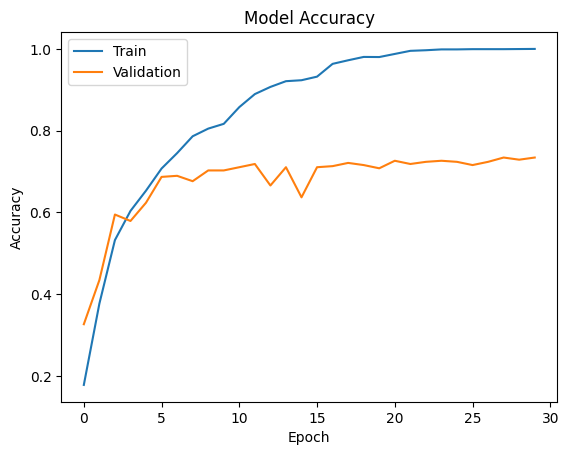

In [276]:
plt.plot(history_1.history['accuracy'])
plt.plot(history_1.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Observations:

We can see from the above plot that the training accuracy of the model was good but the validation accuracy was not good.

The model seems to overfit on the data.

# Evaluating Model1 on test data

In [277]:
accuracy = model1.evaluate(X_test_normalized, y_test_encoded, verbose=2)


30/30 - 0s - loss: 1.7497 - accuracy: 0.6811 - 98ms/epoch - 3ms/step


**The model1 is giving ~68% accuracy on the test/unseen data.**

# Generating the predictions using test data

In [278]:
# Here we would get the output as probablities for each category
y_pred1=model1.predict(X_test_normalized)

30/30 [==============================] - 0s 2ms/step


In [279]:
y_pred1

array([[2.2987963e-26, 2.8384855e-13, 5.5256862e-11, ..., 2.0011310e-06,
        9.9993277e-01, 5.3156980e-13],
       [3.7000701e-02, 1.0624351e-11, 1.2506959e-09, ..., 3.8056331e-15,
        3.1669536e-08, 7.5564143e-04],
       [3.9459584e-26, 2.3855588e-05, 3.3100338e-07, ..., 5.1825293e-05,
        9.9992144e-01, 9.1526939e-11],
       ...,
       [7.9226840e-16, 2.9878849e-12, 1.5901062e-14, ..., 1.5506890e-04,
        9.4369838e-11, 4.2638578e-07],
       [2.0926935e-10, 1.0312399e-04, 9.9885273e-01, ..., 6.2650279e-04,
        1.5650109e-07, 2.5037190e-04],
       [1.6908931e-08, 5.5975024e-02, 9.2789501e-01, ..., 1.4270269e-03,
        6.5461843e-04, 1.2929792e-02]], dtype=float32)

**Plotting the Confusion Matrix**

The Confusion matrix is also defined as an inbuilt function in the TensorFlow module, so we can use that for evaluating the classification model.

The Confusion matrix expects categorical data as input. However, y_test_encoded is an encoded value, whereas y_pred has probabilities. So,we must retrieve the categorical values from the encoded values.

We will use the argmax() function to obtain the maximum value over each category on both y_test_encoded and y_pred and obtain their respective classes.

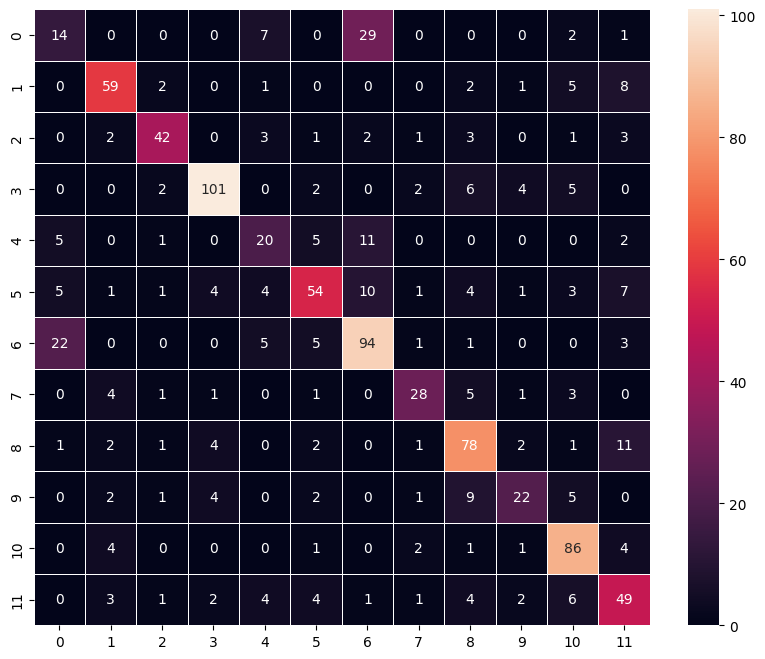

In [280]:
# Obtaining the categorical values from y_test_encoded and y_pred1
y_pred1_arg=np.argmax(y_pred1,axis=1)
y_test_arg=np.argmax(y_test_encoded,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred1_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

**Observations**

We observe that some of the classes are not predicted correctly.

In comparison to the rest, we can see that classes 10 and 2 are well classified.

We can also observe that classes 0,4, 5 and 6 have comparatively higher misclassifications. 0 is being misclasified as 6 and vice-versa.

In [281]:
# Print the metrics
print(classification_report(y_test_arg,y_pred1_arg))

              precision    recall  f1-score   support

           0       0.30      0.26      0.28        53
           1       0.77      0.76      0.76        78
           2       0.81      0.72      0.76        58
           3       0.87      0.83      0.85       122
           4       0.45      0.45      0.45        44
           5       0.70      0.57      0.63        95
           6       0.64      0.72      0.68       131
           7       0.74      0.64      0.68        44
           8       0.69      0.76      0.72       103
           9       0.65      0.48      0.55        46
          10       0.74      0.87      0.80        99
          11       0.56      0.64      0.59        77

    accuracy                           0.68       950
   macro avg       0.66      0.64      0.65       950
weighted avg       0.68      0.68      0.68       950



The model (model 1) precision/recall/f1 scores are low for class 0 as well as class 4. 

# Model2
As we can see, our initial model appears to overfit. Therefore we'll try to address this problem with data augmentation, Batch Normalization and Dropout. Let us also add more dense layers and see if it helps with the predictions. 

# Data Augmentation
In most of the real-world case studies, it is challenging to acquire a large number of images and then train CNNs. To overcome this problem, one approach we might consider is Data Augmentation. CNNs have the property of translational invariance, which means they can recognise an object even if its appearance shifts translationally in some way.
Taking this attribute into account, we can augment the images using the techniques listed below -
1. Horizontal Flip (should be set to True/False)
2. Vertical Flip (should be set to True/False)
3. Height Shift (should be between 0 and 1)
4. Width Shift (should be between 0 and 1)
5. Rotation (should be between 0 and 180)
6. Shear (should be between 0 and 1)
7. Zoom (should be between 0 and 1) etc.

Also, we cannot use data augmentation on the validation/test data sets.

In [282]:
# Creating new data
train_datagen = ImageDataGenerator(shear_range = 0.2,rotation_range=180,  # randomly rotate images in the range
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally
        height_shift_range=0.1,  # randomly shift images vertically 
        horizontal_flip=True,  # randomly flip images horizontally
        vertical_flip=True  # randomly flip images vertically
    )

In [283]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [284]:
# Intializing a sequential model
model2 = Sequential()

# Adding first conv layer with 64 filters and kernel size 3x3 , padding 'same' provides the output size same as the input size
# Input_shape denotes input image dimension images
model2.add(Conv2D(64, (3, 3), activation='relu', padding="same", input_shape=(64, 64, 3)))

# Adding max pooling to reduce the size of output of first conv layer
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())
model2.add(Conv2D(32, (3, 3), activation='relu', padding="same"))
model2.add(MaxPooling2D((2, 2), padding = 'same'))
model2.add(BatchNormalization())
# flattening the output of the conv layer after max pooling to make it ready for creating dense connections
model2.add(Flatten())

# Adding a fully connected dense layer with 128 neurons    
model2.add(Dense(128, activation='relu'))
#Introducing Dropout to addess overfitting
model2.add(Dropout(0.3))
model2.add(Dense(64, activation='relu'))
model2.add(Dropout(0.3))
model2.add(Dense(32, activation='relu'))
# Adding the output layer with 12 neurons and activation functions as softmax since this is a multi-class classification problem  
model2.add(Dense(12, activation='softmax'))


# Compile model
model2.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                        

In [285]:
history2 = model2.fit(train_datagen.flow(X_train_normalized,y_train_encoded,
                                       batch_size=64, 
                                       seed=1,
                                       shuffle=False),
                    epochs=30,
                    steps_per_epoch=X_train_normalized.shape[0] // 64,
                    class_weight = class_weights,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/30
53/53 [==============================] - 7s 77ms/step - loss: 2.7410 - accuracy: 0.2339 - val_loss: 2.4311 - val_accuracy: 0.1368
Epoch 2/30
53/53 [==============================] - 4s 76ms/step - loss: 2.1642 - accuracy: 0.3504 - val_loss: 2.4676 - val_accuracy: 0.1368
Epoch 3/30
53/53 [==============================] - 4s 78ms/step - loss: 1.8802 - accuracy: 0.4178 - val_loss: 2.5501 - val_accuracy: 0.1368
Epoch 4/30
53/53 [==============================] - 4s 75ms/step - loss: 1.7948 - accuracy: 0.4446 - val_loss: 3.2774 - val_accuracy: 0.1368
Epoch 5/30
53/53 [==============================] - 4s 77ms/step - loss: 1.6637 - accuracy: 0.4794 - val_loss: 3.2284 - val_accuracy: 0.1368
Epoch 6/30
53/53 [==============================] - 4s 78ms/step - loss: 1.5972 - accuracy: 0.4931 - val_loss: 4.0374 - val_accuracy: 0.1368
Epoch 7/30
53/53 [==============================] - 4s 74ms/step - loss: 1.5506 - accuracy: 0.5180 - val_loss: 2.9823 - val_accuracy: 0.1526
Epoch 8/30
53

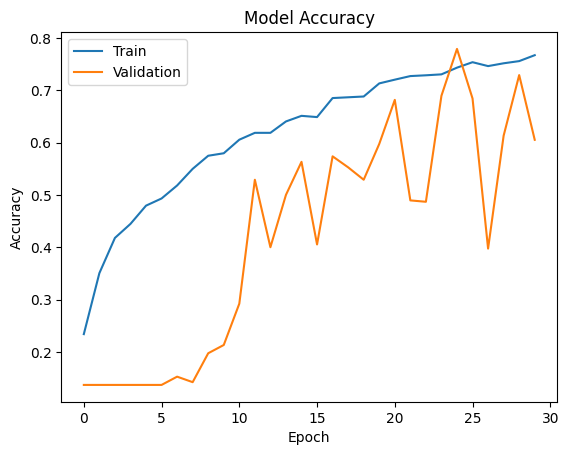

In [286]:
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()


**There is quite a bit of fluctuation in the accuracy curve plotted against the validation data.**

**Data Augmentation, Dropout, BatchNormalization introduced to solve overfitting do not seem to have made much difference. The model is overfitting with 77% accuracy on the training data and 61% accuracy on the validation data.**

In [287]:
accuracy = model2.evaluate(X_test_normalized, y_test_encoded, verbose=2)


30/30 - 0s - loss: 1.5547 - accuracy: 0.6337 - 131ms/epoch - 4ms/step


**The model2 is giving ~63% accuracy on the test/unseen data.**

In [288]:
# Here we would get the output as probablities for each category
y_pred2=model2.predict(X_test_normalized)


30/30 [==============================] - 0s 2ms/step


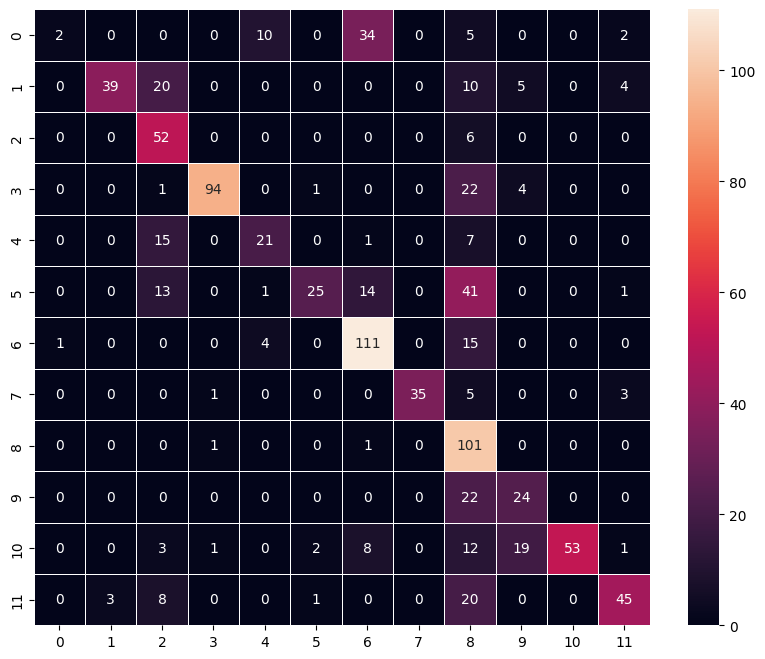

In [289]:
# Obtaining the categorical values from y_pred2
y_pred2_arg=np.argmax(y_pred2,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred2_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Observation:

We observe that quite a few classes are not predicted correctly. Barely any seedlings from class 0 seem to have been classified correctly. 34 out of the 53 samples in class 0 seem to have been misclassified as belonging to class 6.

In comparison to the rest, we can see that classes 2,7,8 are well classified.

We can also observe that classes 0,3,4,5,9,10,11 have comparatively higher misclassifications. 



In [290]:
# Print the metrics
print(classification_report(y_test_arg,y_pred2_arg))

              precision    recall  f1-score   support

           0       0.67      0.04      0.07        53
           1       0.93      0.50      0.65        78
           2       0.46      0.90      0.61        58
           3       0.97      0.77      0.86       122
           4       0.58      0.48      0.53        44
           5       0.86      0.26      0.40        95
           6       0.66      0.85      0.74       131
           7       1.00      0.80      0.89        44
           8       0.38      0.98      0.55       103
           9       0.46      0.52      0.49        46
          10       1.00      0.54      0.70        99
          11       0.80      0.58      0.68        77

    accuracy                           0.63       950
   macro avg       0.73      0.60      0.60       950
weighted avg       0.75      0.63      0.62       950



Class 0 has the lowest recall/f1-score(s) amongst all the 12 classes.

# Transfer Learning using VGG16
Let's try again, but this time, we will be using the idea of Transfer Learning. We will be loading a pre-built architecture - VGG16, which was trained on the ImageNet dataset and is the runner-up in the ImageNet competition in 2014.

For training VGG16, we will directly use the convolutional and pooling layers and freeze their weights i.e. no training will be done on them. For classification, we will replace the existing fully-connected layers with FC layers created specifically for our problem.

Let us also add more dense layers with more neurons.

**Building Model3**

In [291]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)

In [292]:
vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 16, 16, 128)       0     

In [293]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model.layers:
    layer.trainable = False

In [294]:
model3 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model3.add(vgg_model)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model3.add(Flatten())

# Adding a dense output layer
model3.add(Dense(1024, activation='relu'))
model3.add(BatchNormalization())

model3.add(Dense(512, activation='relu'))
model3.add(BatchNormalization())

model3.add(Dense(256, activation='relu'))
model3.add(Dropout(0.3))

model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.2))

model3.add(Dense(64, activation='relu'))

model3.add(Dense(32, activation='relu'))
model3.add(Dense(12, activation='softmax'))

# Compile model
model3.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 1024)              2098176   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

In [295]:
history_vgg16 = model3.fit(train_datagen.flow(X_train_normalized,y_train_encoded, #Using the augmented data
                                       batch_size=64, 
                                       seed=1,
                                       shuffle=False),
                    epochs=30,
                    steps_per_epoch=X_train_normalized.shape[0] // 64,
                    class_weight = class_weights,
                    validation_data=(X_val_normalized,y_val_encoded),
                    verbose=1)

Epoch 1/30
53/53 [==============================] - 8s 82ms/step - loss: 2.4217 - accuracy: 0.2989 - val_loss: 2.1155 - val_accuracy: 0.2579
Epoch 2/30
53/53 [==============================] - 5s 88ms/step - loss: 1.9090 - accuracy: 0.3865 - val_loss: 1.7171 - val_accuracy: 0.3816
Epoch 3/30
53/53 [==============================] - 4s 81ms/step - loss: 1.7249 - accuracy: 0.4482 - val_loss: 1.7644 - val_accuracy: 0.4000
Epoch 4/30
53/53 [==============================] - 4s 83ms/step - loss: 1.6724 - accuracy: 0.4636 - val_loss: 1.6037 - val_accuracy: 0.4079
Epoch 5/30
53/53 [==============================] - 5s 84ms/step - loss: 1.5974 - accuracy: 0.4741 - val_loss: 1.4688 - val_accuracy: 0.4921
Epoch 6/30
53/53 [==============================] - 4s 79ms/step - loss: 1.5385 - accuracy: 0.4946 - val_loss: 1.4840 - val_accuracy: 0.5132
Epoch 7/30
53/53 [==============================] - 4s 83ms/step - loss: 1.4641 - accuracy: 0.5304 - val_loss: 1.3137 - val_accuracy: 0.5368
Epoch 8/30
53

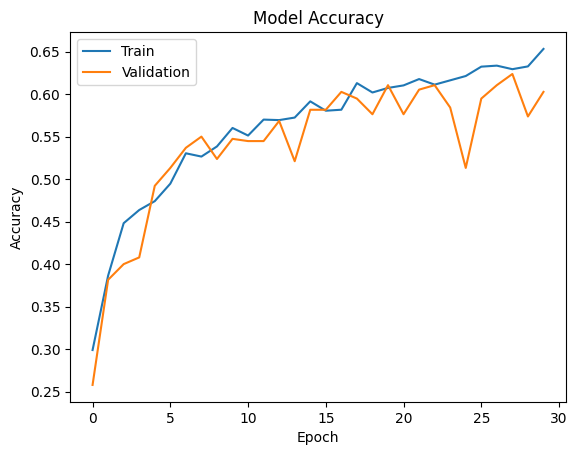

In [296]:
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**The model is not overfitting. In this aspect, it certainly is an improvement over models 1 & 2.** 

**Despite the use of transfer learning, the model (model3) did not yeild desired accuracy rates. The accuracy rates are 65 and 60 for training and validation sets respectively.**

In [297]:
accuracy = model3.evaluate(X_test_normalized, y_test_encoded, verbose=2)


30/30 - 0s - loss: 1.1599 - accuracy: 0.5863 - 451ms/epoch - 15ms/step


**The model3 is giving ~59% accuracy on the test/unseen data.**

In [298]:
# Here we would get the output as probablities for each category
y_pred3=model3.predict(X_test_normalized)

30/30 [==============================] - 1s 14ms/step


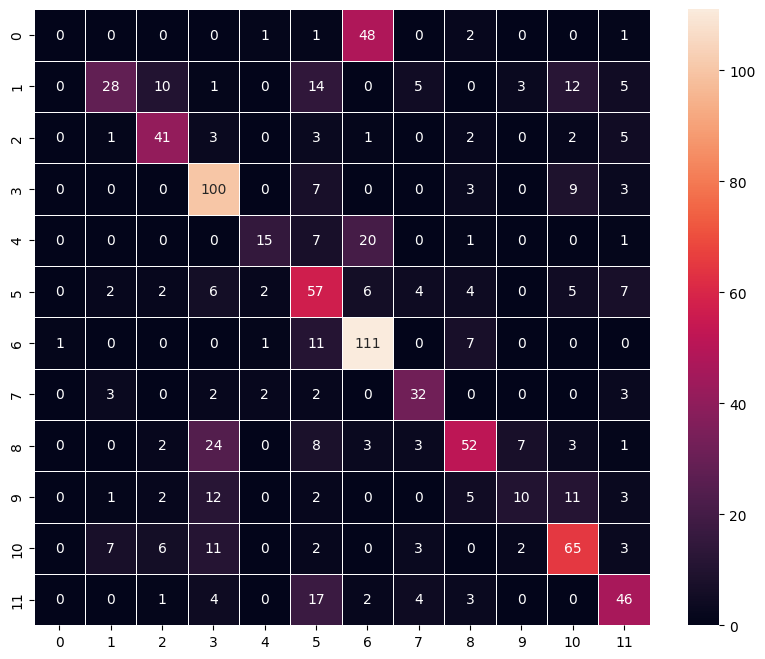

In [299]:
# Obtaining the categorical values from y_pred3
y_pred3_arg=np.argmax(y_pred3,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_arg,y_pred3_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Observation:


We observe that a few classes are not predicted correctly.  Class 0 is mostly misclassified as class 6. Not a single seedling in this category was correctly identified by the model.

Besides class 0, Classes 1,4,5,8,9,10,11 have high misclassifications as well.






In [300]:
# Print the metrics
print(classification_report(y_test_arg,y_pred3_arg))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        53
           1       0.67      0.36      0.47        78
           2       0.64      0.71      0.67        58
           3       0.61      0.82      0.70       122
           4       0.71      0.34      0.46        44
           5       0.44      0.60      0.50        95
           6       0.58      0.85      0.69       131
           7       0.63      0.73      0.67        44
           8       0.66      0.50      0.57       103
           9       0.45      0.22      0.29        46
          10       0.61      0.66      0.63        99
          11       0.59      0.60      0.59        77

    accuracy                           0.59       950
   macro avg       0.55      0.53      0.52       950
weighted avg       0.56      0.59      0.56       950



Class 0 has the lowest precision/recall/f1-scores compared to all other classes. 

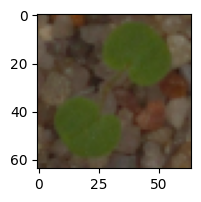

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


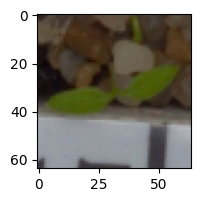

1/1 [==============================] - 0s 18ms/step
Predicted Label ['Fat Hen']
True Label Common Chickweed


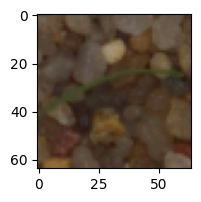

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


In [301]:
# Visualizing the predicted and actual label of images from test data
import math    
plt.figure(figsize=(2,2))
plt.imshow(X_test[2])
plt.show()
print('Predicted Label', encoder.inverse_transform(model3.predict((X_test_normalized[2].reshape(1,64,64,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', encoder.inverse_transform(y_test_encoded)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', encoder.inverse_transform(model3.predict((X_test_normalized[33].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', encoder.inverse_transform(y_test_encoded)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', encoder.inverse_transform(model3.predict((X_test_normalized[36].reshape(1,64,64,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', encoder.inverse_transform(y_test_encoded)[36])  

**Inspite of the low accuracy rates, 2 out of the 3 random samples were classified correctly.**

# Model4 - Transfer Learning using VGG16 - Using original image size - 128x128


We will re-use the configuration of model3, but will use the original images 128x128 (vs 64x64 resized images used in model3).

In [302]:
# Clearing backend
backend.clear_session()

# Fixing the seed for random number generators
import random
np.random.seed(1)
random.seed(1)
tf.random.set_seed(1)



Using the original images to split and normalize the data.

In [303]:
X_temp, X_test_org, y_temp, y_test_org = train_test_split(np.array(images),labels , test_size=0.2, random_state=1,stratify=labels)
X_train_org, X_val_org, y_train_org, y_val_org = train_test_split(X_temp,y_temp , test_size=0.1, random_state=1,stratify=y_temp)

print(X_train_org.shape,y_train.shape)
print(X_val_org.shape,y_val.shape)
print(X_test_org.shape,y_test.shape)

# Convert labels from names to one hot vectors.
# Labelbinarizer works similar to onehotencoder
y_train_encoded_org = encoder.fit_transform(y_train_org)
y_val_encoded_org=encoder.transform(y_val_org)
y_test_encoded_org=encoder.transform(y_test_org)

# Normalizing the image pixels
X_train_normalized_org = X_train_org.astype('float32')/255.0
X_val_normalized_org = X_val_org.astype('float32')/255.0
X_test_normalized_org = X_test_org.astype('float32')/255.0

(3420, 128, 128, 3) (3420, 1)
(380, 128, 128, 3) (380, 1)
(950, 128, 128, 3) (950, 1)


In [304]:
vgg_model2 = VGG16(weights='imagenet', include_top = False, input_shape = (128,128,3)) # Using the original image size of 128x128
vgg_model2.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0     

In [305]:
# Making all the layers of the VGG model non-trainable. i.e. freezing them
for layer in vgg_model2.layers:
    layer.trainable = False

In [306]:
model4 = Sequential()

# Adding the convolutional part of the VGG16 model from above
model4.add(vgg_model2)

# Flattening the output of the VGG16 model because it is from a convolutional layer
model4.add(Flatten())

# Adding a dense output layer
model4.add(Dense(1024, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(512, activation='relu'))
model4.add(BatchNormalization())

model4.add(Dense(256, activation='relu'))
model4.add(Dropout(0.3))

model4.add(Dense(128, activation='relu'))
model4.add(Dropout(0.2))

model4.add(Dense(64, activation='relu'))

model4.add(Dense(32, activation='relu'))
model4.add(Dense(12, activation='softmax'))

# Compile model
model4.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Generating the summary of the model
model4.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1024)              8389632   
                                                                 
 batch_normalization (BatchN  (None, 1024)             4096      
 ormalization)                                                   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                        

In [307]:
history_vgg16_2 = model4.fit(train_datagen.flow(X_train_normalized_org,y_train_encoded_org,
                                       batch_size=64, 
                                       seed=1,
                                       shuffle=False),
                    epochs=30,
                    steps_per_epoch=X_train_normalized_org.shape[0] // 64,
                    class_weight = class_weights,
                    validation_data=(X_val_normalized_org,y_val_encoded_org),
                    verbose=1)

Epoch 1/30
53/53 [==============================] - 16s 231ms/step - loss: 2.3622 - accuracy: 0.2880 - val_loss: 2.8096 - val_accuracy: 0.1474
Epoch 2/30
53/53 [==============================] - 13s 237ms/step - loss: 1.7866 - accuracy: 0.4240 - val_loss: 1.6868 - val_accuracy: 0.4263
Epoch 3/30
53/53 [==============================] - 13s 238ms/step - loss: 1.5508 - accuracy: 0.5018 - val_loss: 2.2782 - val_accuracy: 0.3711
Epoch 4/30
53/53 [==============================] - 12s 232ms/step - loss: 1.4315 - accuracy: 0.5396 - val_loss: 1.4398 - val_accuracy: 0.4974
Epoch 5/30
53/53 [==============================] - 13s 238ms/step - loss: 1.3193 - accuracy: 0.5766 - val_loss: 1.1945 - val_accuracy: 0.5895
Epoch 6/30
53/53 [==============================] - 13s 239ms/step - loss: 1.2897 - accuracy: 0.5945 - val_loss: 1.0653 - val_accuracy: 0.6289
Epoch 7/30
53/53 [==============================] - 13s 244ms/step - loss: 1.1990 - accuracy: 0.6278 - val_loss: 1.1182 - val_accuracy: 0.6132

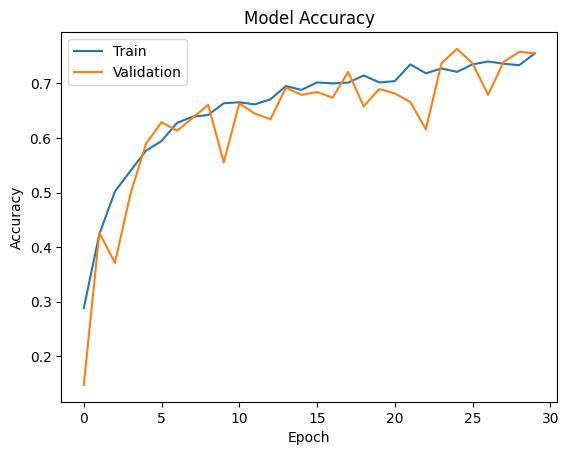

In [308]:
plt.plot(history_vgg16_2.history['accuracy'])
plt.plot(history_vgg16_2.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

**The model4 is not overfitting and produced good accuracy rates (75% and 75%) across both the training and validation datasets.**

In [309]:
accuracy = model4.evaluate(X_test_normalized_org, y_test_encoded_org, verbose=2)

30/30 - 1s - loss: 0.7884 - accuracy: 0.7326 - 1s/epoch - 44ms/step


**The model4 is giving ~73% accuracy with the test/unseen data - the best rate across all the 4 models.**

In [310]:
# Here we would get the output as probablities for each category
y_pred4=model4.predict(X_test_normalized_org)

30/30 [==============================] - 1s 44ms/step


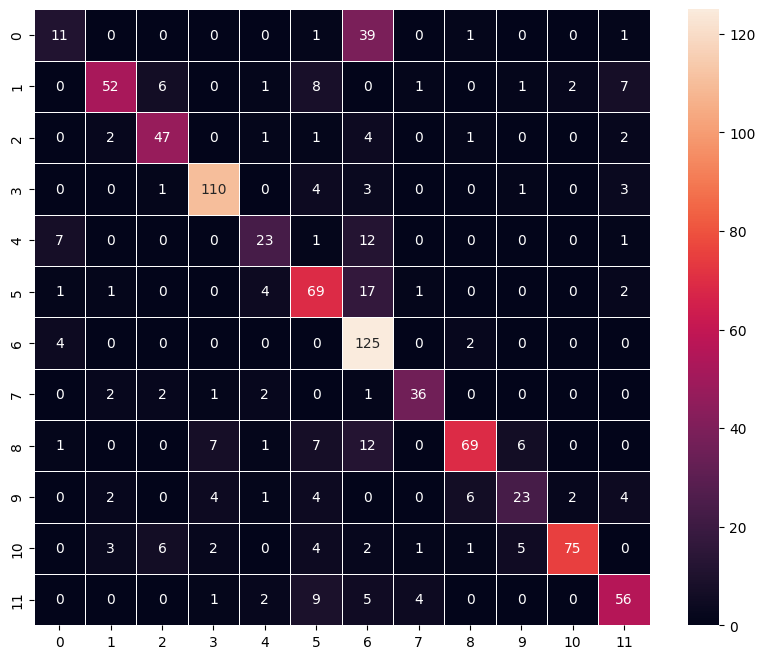

In [311]:
# Obtaining the categorical values from y_pred4
y_pred4_arg=np.argmax(y_pred4,axis=1)
y_test_org_arg=np.argmax(y_test_encoded_org,axis=1)

# Plotting the Confusion Matrix using confusion matrix() function which is also predefined tensorflow module
confusion_matrix = tf.math.confusion_matrix(y_test_org_arg,y_pred4_arg)
f, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(
    confusion_matrix,
    annot=True,
    linewidths=.4,
    fmt="d",
    square=True,
    ax=ax
)
plt.show()

Observation:

We observe that most of the classes are predicted correctly.

Class 0 remains to be the class with the most number of misclassifications. The model was able to correctly predict only 11 out of the 53 samples of class 0. There are some misclassifications in classes 4, 8 and 11 as well. Besides these 4 classes, the model seems to have classified the rest of the classes reasonably well.

Overall, this seems to be our best model.


In [312]:
# Print the metrics
print(classification_report(y_test_org_arg,y_pred4_arg))

              precision    recall  f1-score   support

           0       0.46      0.21      0.29        53
           1       0.84      0.67      0.74        78
           2       0.76      0.81      0.78        58
           3       0.88      0.90      0.89       122
           4       0.66      0.52      0.58        44
           5       0.64      0.73      0.68        95
           6       0.57      0.95      0.71       131
           7       0.84      0.82      0.83        44
           8       0.86      0.67      0.75       103
           9       0.64      0.50      0.56        46
          10       0.95      0.76      0.84        99
          11       0.74      0.73      0.73        77

    accuracy                           0.73       950
   macro avg       0.74      0.69      0.70       950
weighted avg       0.75      0.73      0.73       950



**Leaving aside the metrics for class 0,the precision, recall and f1-scores from model4 are superior to the other 3 models.**

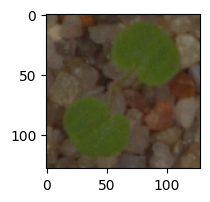

1/1 [==============================] - 0s 21ms/step
Predicted Label ['Small-flowered Cranesbill']
True Label Small-flowered Cranesbill


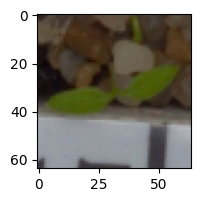

1/1 [==============================] - 0s 19ms/step
Predicted Label ['Common Chickweed']
True Label Common Chickweed


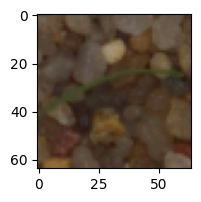

1/1 [==============================] - 0s 20ms/step
Predicted Label ['Loose Silky-bent']
True Label Loose Silky-bent


In [313]:
# Visualizing the predicted and actual label of images from test data
import math    
plt.figure(figsize=(2,2))
plt.imshow(X_test_org[2])
plt.show()
print('Predicted Label', encoder.inverse_transform(model4.predict((X_test_normalized_org[2].reshape(1,128,128,3)))))   # reshaping the input image as we are only trying to predict using a single image
print('True Label', encoder.inverse_transform(y_test_encoded_org)[2])                                               # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[33])
plt.show()
print('Predicted Label', encoder.inverse_transform(model4.predict((X_test_normalized_org[33].reshape(1,128,128,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', encoder.inverse_transform(y_test_encoded_org)[33])                                              # using inverse_transform() to get the output label from the output vector

plt.figure(figsize=(2,2))
plt.imshow(X_test[36])
plt.show()
print('Predicted Label', encoder.inverse_transform(model4.predict((X_test_normalized_org[36].reshape(1,128,128,3)))))  # reshaping the input image as we are only trying to predict using a single image
print('True Label', encoder.inverse_transform(y_test_encoded_org)[36])  

**All the 3 samples that we randomly picked have been predicted correctly.**

# Model Performance Comparison

In [314]:
pd.DataFrame({'Models':['Base CNN Model','CNN Model with Data Augmentation','Transfer Learning Model with resized images', 'Transfer Learning Model with original images'],'Train Accuracy':['100%','77%','65%','75%'],'Validation Accuracy':['73%','61%','60%', '75%'],'Test Accuracy':['68%','63%','59%', '73%']})


Models Train Accuracy  \
0                                Base CNN Model           100%   
1              CNN Model with Data Augmentation            77%   
2   Transfer Learning Model with resized images            65%   
3  Transfer Learning Model with original images            75%   

  Validation Accuracy Test Accuracy  
0                 73%           68%  
1                 61%           63%  
2                 60%           59%  
3                 75%           73%

**Conclusion**

The dataset is imbalanced. Class weights were used to handle the data imbalance. 

Data Augmentation was used to create more data samples.

It appeared that GaussianBlur would be ineffective because the denoised image did not seem to contain any relevant information. Since the model would struggle to categorize these blurred images, gaussian blur was not employed.

Four models were built to predict the class of the seedling - 2 ordinary CNN models (model1 and model2) and 2 models built using pre-trained VGG16 (model3  and model4). Models 1, 2 and 3 were configured to use the resized images (64x64). Model 4 was configured to use the original images of size 128x128. Model4 predicted the majority of the classes better than the other 3 models.

The test accuracy of the VGG16 model built using the original images (model4) is 73%. The very same configuration(VGG16) using resized images (model3) yeilded lower accuracy values (59% accuracy on the test set).

Both the VGG16 models (models 3 & 4) solved the issue of overfitting that was quite prominent in vanilla CNN models (models 1 & 2).

All the 4 models exhibited difficulty in correctly classifying Black-grass(class 0) - the training data had 189 samples of Black-grass (5.5%). The models misclassified 'Black-grass' as 'Loose silky-bent' (class 6) which was the majority of the sampleset (471 - ~14%). Having balanaced dataset with more samples of Black-grass will definitely help the prediction rates.

Simply employing the transfer learning model produced a better/consistant outcome than an ordinary CNN.